In [1]:
from lib import save_animation, integrate_rk, integrate_rk_delta, domain, get_derivative_matrix, initial_gauss, save_animation_two
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_space_pts = 1000
x, l, m, r = domain(n_space_pts, d=100)
y = np.zeros((len(x), 2))
y[:, 0] = initial_gauss(x, l, premik=-25)
y1 = np.zeros((len(x), 2))


def gauss_exact(x, t, c, initial_premik=-25):
    xs = np.exp(-(x-c*t-initial_premik)**2) / 2 + np.exp(-(x+c*t-initial_premik)**2) / 2
    vs = -c * (x-c*t-initial_premik) * np.exp(-(x-c*t-initial_premik)**2) / 2 + c * (x+c*t-initial_premik) * np.exp(-(x+c*t-initial_premik)**2) / 2
    return np.array([xs, vs]).T



In [3]:
import matplotlib.pyplot as plt
def plot_static_img(x, zg, sp, t_idx):
    fig, ax = plt.subplots(2, figsize=(9, 6))
    ax[0].set_xlim(-100, 100)
    ax[0].set_ylim(-1, 1)
    ax[1].set_xlim(-100, 100)
    ax[1].set_ylim(-1, 1)
    ax[0].plot(x, zg[t_idx, :, 0])
    ax[1].plot(x, sp[t_idx, :, 0])

    ax[0].grid()
    ax[1].grid()
    fig.tight_layout()
    return fig

def plot_static_img_two(x, zg, sp, zg1, sp1, t_idx, upper_ylim=1, lower_ylim=1):
    fig, ax = plt.subplots(2, figsize=(9, 6))
    ax[0].set_xlim(-100, 100)
    ax[0].set_ylim(-1*upper_ylim, upper_ylim)
    ax[1].set_xlim(-100, 100)
    ax[1].set_ylim(-1*lower_ylim, lower_ylim)
    ax[0].plot(x, zg[t_idx, :, 0])
    ax[1].plot(x, sp[t_idx, :, 0])
    ax[0].plot(x, zg1[t_idx, :, 0], "--")
    ax[1].plot(x, sp1[t_idx, :, 0], "--")
    ax[1].set_xlabel("x")
    ax[0].set_ylabel("u")
    ax[1].set_ylabel("-v")
    ax[0].grid()
    ax[1].grid()
    fig.tight_layout()
    return fig

In [4]:
def rubberband_force(lower_y, upper_y):
    Fu = -1 * max(0, lower_y + upper_y)
    Fv = -1 * max(0, lower_y + upper_y)
    return Fu, Fv


In [6]:
def get_error(n_time_steps, order_derivative, n_space_pts):
    x, l, m, r = domain(n_space_pts, d=100)
    y = np.zeros((len(x), 2))
    y[:, 0] = gauss_exact(x, 0, 1)[:, 0]
    y1 = np.zeros((len(x), 2))
    zg_resitev, sp_resitev, t = integrate_rk_delta(y, y1, domain(n_space_pts, d=100), get_derivative_matrix(2*n_space_pts+1, order=order_derivative), q_mu_u=1, q_mu_v=1, T=300, n_steps=n_time_steps, mu=1., force_fn=lambda x,y: (0., 0.))
    times = np.linspace(0, 50, 100)
    errors = []
    for plot_time in times:
        time_idx = int(plot_time/300*len(t))
        res = (zg_resitev[time_idx] - gauss_exact(x, plot_time, 1))[:, 0]
        error = np.sum(res**2) / len(res)
        errors.append(error)
    return times, errors, zg_resitev, x

In [7]:
ts, errs = {}, {}
for order in [3, 5, 7]:
    ts[order], errs[order], _ , _ = get_error(10000, order, 200)


/tmp/ipykernel_2129/4104051880.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


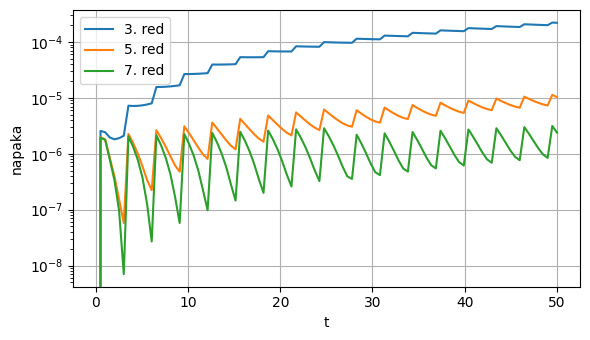

In [92]:
fig, ax = plt.subplots(figsize=(6, 3.5))
for order in ts:
    ax.plot(ts[order], errs[order], label=str(order) + ". red")
ax.legend()
ax.grid()
ax.set_xlabel("t")
ax.set_ylabel("napaka")
ax.set_yscale("log")
fig.tight_layout()
fig.show()
fig.savefig("order_vs_time_error_400.pdf")



In [86]:
final_errs, n_ptss = {}, {}
for order in [3, 5, 7]:
    if order not in final_errs:
        final_errs[order] = []
        n_ptss[order] = []
    for npts in [100, 200, 300, 500, 700, 1000, 1500]:
        n_ptss[order].append(2*npts+1)
        _, errs, _ , _ = get_error(10000, order, npts)
        final_errs[order].append(errs[-1])


NameError: name 'final_errs' is not defined

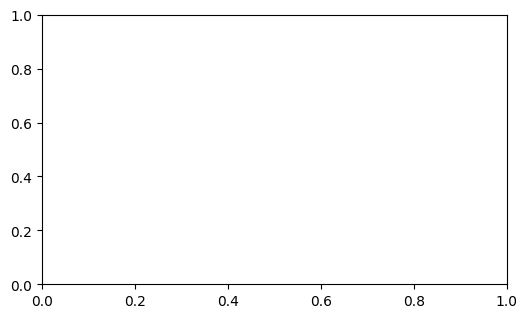

In [41]:
fig, ax = plt.subplots(figsize=(6, 3.5))
for order in final_errs:
    ax.plot(n_ptss[order], final_errs[order], ".-", label=str(order) + ". red")
ax.legend()
ax.grid()
ax.set_xlabel("n")
ax.set_yscale("log")
ax.set_ylabel("napaka")
fig.tight_layout()
fig.show()
fig.savefig("10k_time_steps_error_vs_n.pdf")

In [73]:
def energy(y, h):
    velocities = y[:, 1]**2
    #y_der =((y[:, 0] - np.roll(y[:, 0], 1))**2)[1:]/ h**2
    y_der = ((y[:, 0] - np.roll(y[:, 0], 2))**2)[2:] / (2*h)**2
    kinetic_e = 1 / 2 * np.sum(velocities) / len(velocities) * 200
    potential_e = 1 / 2 * np.sum(y_der) / len(y_der) * 200
    return kinetic_e, potential_e

def spring_energy(yupper, ylower):
    midpt = int(len(yupper) / 2)  # also compute energy of the spring
    return 1 / 2 * (yupper[midpt, 0] + ylower[midpt, 0])**2


def get_energy(n_time_steps, order_derivative, n_space_pts):
    x, l, m, r = domain(n_space_pts, d=100)
    y = np.zeros((len(x), 2))
    y[:, 0] = gauss_exact(x, 0, 1, initial_premik=-25)[:, 0]
    y1 = np.zeros((len(x), 2))
    zg_resitev, sp_resitev, t = integrate_rk_delta(y, y1, domain(n_space_pts, d=100), get_derivative_matrix(2*n_space_pts+1, order=order_derivative), q_mu_u=1, q_mu_v=1, T=100, n_steps=n_time_steps, mu=1.)
    h = x[1] - x[0]
    kinetic_es = np.array([energy(y, h)[0] for y in zg_resitev]) + np.array([energy(y, h)[0] for y in sp_resitev])
    potential_es = np.array([energy(y, h)[1] for y in zg_resitev]) + np.array([energy(y, h)[1] for y in sp_resitev])
    spring_es = np.array([spring_energy(y[0], y[1]) for y in zip(zg_resitev, sp_resitev)])

    return t, np.array([kinetic_es, potential_es, spring_es]), zg_resitev, sp_resitev, x

In [97]:
ts, e, zgy, spy, x = get_energy(10000, 3, 500)


/tmp/ipykernel_2580/1871663072.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


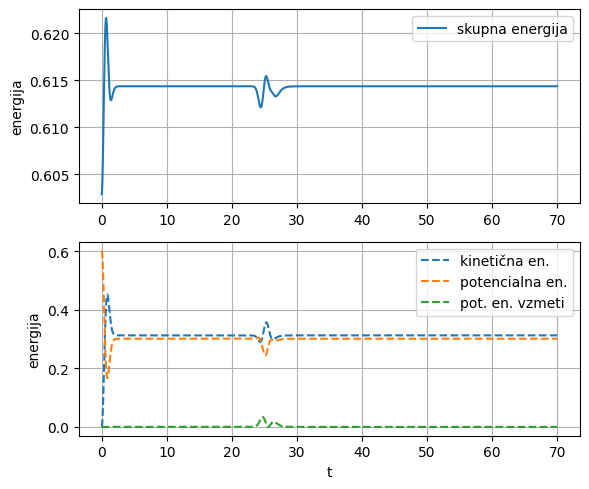

In [98]:
fig, ax = plt.subplots(2, figsize=(6, 5.0))
eall = e[0]+e[1]+e[2]

ax[0].plot(ts[ts<70], eall[ts<70], label="skupna energija")
ax[1].plot(ts[ts<70], e[0][ts<70], "--", label="kinetična en.")
ax[1].plot(ts[ts<70], e[1][ts<70], "--", label="potencialna en.")
ax[1].plot(ts[ts<70], e[2][ts<70], "--", label="pot. en. vzmeti")
ax[0].grid()
ax[1].grid()
ax[1].set_xlabel("t")
ax[0].set_ylabel("energija")
ax[1].set_ylabel("energija")
ax[1].legend()
ax[0].legend()
fig.tight_layout()
fig.show()
fig.savefig("energy_conservation.pdf")


-8.799414752402868e-09

In [34]:
 a = np.array([0,1,2,3,4,5,5.5,5.67])
 a - np.roll(a, 1)[1:]

ValueError: operands could not be broadcast together with shapes (8,) (7,) 